In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
with open(symbols_list_file_name, "r") as f:
    symbols_list = json.load(f)
symbols_list.remove('scbtc') # bad

returns_folder_name = "full_returns"
    
ts_list = []
for symbol in symbols_list:
    save_file_name = symbol + '.csv.gz'
    save_path = os.path.join(os.getcwd(), returns_folder_name, save_file_name)
    df = pd.read_csv(save_path, compression='gzip')
    ts_list.append(df['log_return'].rename(symbol))
all_returns_df = pd.concat(ts_list, axis=1)

# monthly average of commonality (across assets)
# (commonality of one asset = r-squared of regressing its vol on market vol)
increments_list = [20, 60, 120, 240, 720, 1440]

monthly_commonalities_list = []
squared_returns = all_returns_df.pow(2)
for increment in increments_list:
    # calculate asset and market volatilities
    volatilities = squared_returns.groupby(
        squared_returns.index // increment).sum().pow(1./2)
    volatilities['market'] = volatilities.mean(axis=1)

    # prepare datetime and month-end information
    datetime = volatilities.index.to_series().apply(
        lambda x: dt.datetime(2019, 5, 1) + dt.timedelta(minutes=x*increment)
    )
    volatilities = pd.concat([volatilities, datetime], axis=1)
    volatilities.rename(columns={0: 'date'}, inplace=True)
    volatilities['end'] = (
        volatilities.date.dt.date + pd.tseries.offsets.MonthEnd(0)
    )

    # compute r-squared for each month
    r_squareds_list = []
    for group, data in volatilities.groupby('end'):

        non_market = data.drop(['date', 'end', 'market'], axis=1)
        r_squareds = non_market.apply(
            lambda x: sp.stats.linregress(data.market, x)
        ).loc[2,:].pow(2).rename(group, inplace=True)

        r_squareds_list.append(r_squareds)

    # take the average commonality
    monthly_commonality = pd.concat(r_squareds_list, axis=1).mean(axis=0)
    monthly_commonality.rename(str(increment), inplace=True)
    monthly_commonality.reset_index(drop=True, inplace=True)
    
    monthly_commonalities_list.append(monthly_commonality)

# prepare the x-axis
month_ends = pd.Series(
    list(volatilities.groupby('end').groups.keys()), name='month_ends'
)
monthly_commonalities_list.append(month_ends)

# make the final df
monthly_commonalities_df = pd.concat(monthly_commonalities_list, axis=1)

molten = monthly_commonalities_df.melt(
    'month_ends', var_name='frequency', value_name='commonality'
)
plt = sns.lineplot(
    data=molten, x='month_ends', y='commonality', hue='frequency', palette='crest'
)

ticks = plt.xaxis.get_major_ticks()
labels = plt.xaxis.get_ticklabels()
for i, (label, tick) in enumerate(zip(labels, ticks)):
    if i % 3 != 0:
        label.set_visible(False)
        tick.set_visible(False)

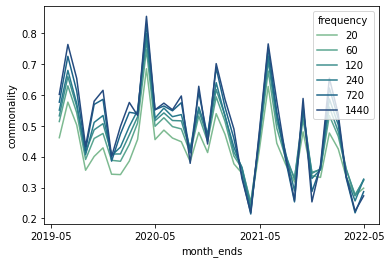

In [13]:
plt.figure

In [15]:
figures_path_base = 'figures/exploration/raw'
figure_name = 'monthly_commonality.png'
figure_path = os.path.join(figures_path_base, figure_name)
plt.figure.savefig(figure_path, bbox_inches='tight', dpi=300)